In [1]:
import matplotlib.pyplot as plt
import numpy as np

import microtool

%matplotlib notebook

# Inversion recovery

## 1. Create a tissue model specifying a T1 and T2

In [2]:
relaxation_model = microtool.tissue_model.RelaxationTissueModel(t1=900e-3, t2=90e-3)
print(relaxation_model)

Tissue model with 3 scalar parameters:
    * t1: 1.0 (scale: 0.9, use: False)
    * t2: 1.0 (scale: 0.09, use: True)
    * s0: 1.0 (scale: 1.0, use: False)


## 2. Create an initial inversion-recovery acquisition scheme
Initial TR = 500 ms, initial TE = 10 ms, initial TI = {50, ..., 400} ms

In [3]:
tr = [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50]
te = [0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02]
ti = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]

ir_scheme = microtool.acquisition_scheme.InversionRecoveryAcquisitionScheme(tr, te, ti)
print(ir_scheme)

Acquisition scheme with 8 measurements and 3 scalar parameters:
    * InversionTime: 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4 s
    * RepetitionTimeExcitation: 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 s
    * EchoTime: 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02 s


<IPython.core.display.Javascript object>


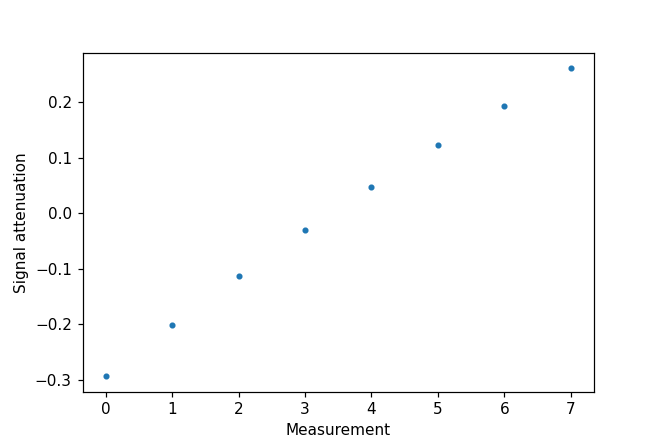

In [4]:
plt.figure(figsize=(6, 4))
plt.plot(relaxation_model(ir_scheme), '.')
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation');

## 3. Optimize the acquisition scheme

In [5]:
noise_variance = 0.1
relaxation_model.optimize(ir_scheme, noise_variance);

Acquisition scheme with 8 measurements and 3 scalar parameters:
    * InversionTime: 0.00048277763312382414, 0.00042826633642856926, 0.023510973357040412, 0.31044914181322925, 0.3484103740763814, 0.38137915460566685, 0.408392055350252, 0.4257562203088172 s
    * RepetitionTimeExcitation: 0.36830771581175825, 0.3676657883131577, 0.30526311513518656, 0.1889295508925005, 0.32529975229039726, 0.39335902207228957, 0.4424406417963763, 0.47291896547905077 s
    * EchoTime: 0.04291137597904245, 0.04346810368229223, 0.05191570597432791, 0.04547724455906302, 0.049051043516450676, 0.04565367570668908, 0.04587670388764706, 0.0450233100086211 s


<IPython.core.display.Javascript object>


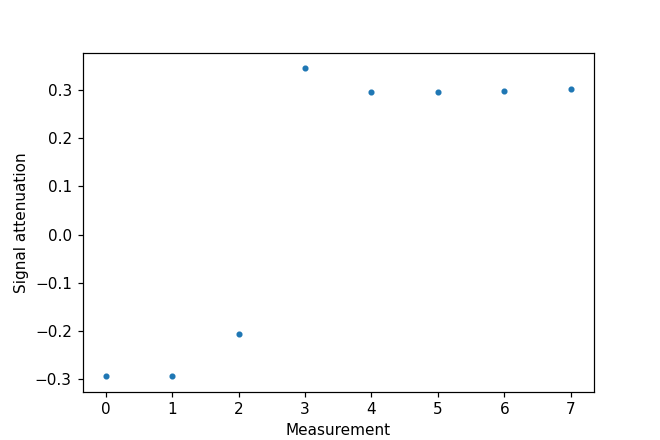

In [6]:
print(ir_scheme)
plt.figure(figsize=(6, 4))
plt.plot(relaxation_model(ir_scheme), '.')
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation');

# dmpyi diffusion model

In [7]:
from dmipy.signal_models.cylinder_models import C1Stick
from dmipy.signal_models.gaussian_models import G1Ball
from dmipy.core.modeling_framework import MultiCompartmentModel

import microtool.dmipy

## 1. Create a 'stick' diffusion model

In [15]:
dmipy_model = MultiCompartmentModel(models=[
    C1Stick(
        mu=[1, 1],  # Orientation in angles.
        lambda_par=0.001 * 1e-6  # Parallel diffusivity in m²/s.
    )
])

## 2. Add a diffusion model to the tissue

In [16]:
diffusion_model = microtool.dmipy.DmipyTissueModel(dmipy_model)
print(diffusion_model)

Tissue model with 4 scalar parameters:
    * C1Stick_1_mu_0: 1.0 (scale: 1.0, use: True)
    * C1Stick_1_mu_1: 1.0 (scale: 1.0, use: True)
    * C1Stick_1_lambda_par: 1e-09 (scale: 1e-09, use: True)
    * s0: 1.0 (scale: 1.0, use: False)


## 3. Create an initial diffusion acquisition scheme

In [17]:
b_values = np.array([0, 1000, 2000, 3000])  # s/mm²
b_vectors = np.array([[0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]])
pulse_widths = np.full(b_values.shape, 0.01)  # s
pulse_intervals = np.full(b_values.shape, 0.03)  # s

diffusion_scheme = microtool.acquisition_scheme.DiffusionAcquisitionScheme(b_values, b_vectors, pulse_widths, pulse_intervals)
print(diffusion_scheme)

Acquisition scheme with 4 measurements and 5 scalar parameters:
    * DiffusionBValue: 0.0, 1000.0, 2000.0, 3000.0 s/mm²
    * DiffusionGradientAnglePhi: 0.0, 0.0, 1.5707963267948966, 0.0 rad (fixed parameter)
    * DiffusionGradientAngleTheta: 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 0.0 rad (fixed parameter)
    * DiffusionPulseWidth: 0.01, 0.01, 0.01, 0.01 s (fixed parameter)
    * DiffusionPulseInterval: 0.03, 0.03, 0.03, 0.03 s (fixed parameter)


<IPython.core.display.Javascript object>


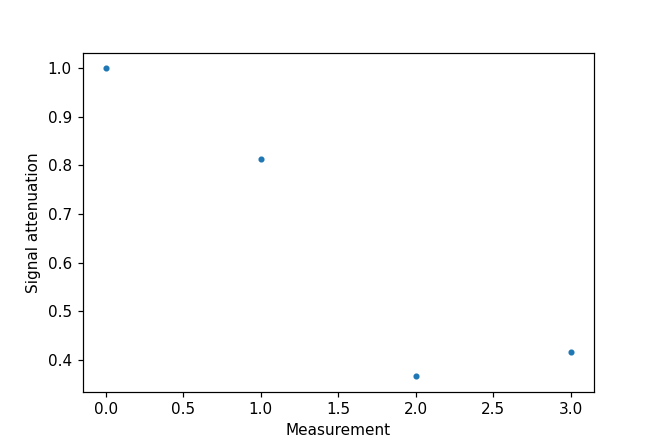

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(diffusion_model(diffusion_scheme), '.')
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation');

## 5. Calculate the Cramer-Rao lower bound loss

In [19]:
jacobian = diffusion_model.jacobian(diffusion_scheme)  # Jacobian of the signal with respect to the relevant tissue parameters.
scales = [p.scale for p in diffusion_model.get_parameters().values()]  # Tissue parameter scales.
uses = [p.use for p in diffusion_model.get_parameters().values()]  # Tissue parameter scales.
noise_variance = 0.1
microtool.optimize.crlb_loss(jacobian, scales, uses, noise_variance)

21.656251987984405

## 6. Optimize the acquisition scheme

In [20]:
diffusion_model.optimize(diffusion_scheme, noise_variance);

C:\development\microtool\venv\lib\site-packages\dmipy\core\acquisition_scheme.py:179: UserWarning: No b0 measurements were detected. Check if the b0_threshold option is high enough, or if there is a mistake in the acquisition design.
  warn(msg)


Acquisition scheme with 4 measurements and 5 scalar parameters:
    * DiffusionBValue: 66.22393253014761, 206.20765747865255, 6502.2243735227485, 8.077331510289953 s/mm²
    * DiffusionGradientAnglePhi: 0.0, 0.0, 1.5707963267948966, 0.0 rad (fixed parameter)
    * DiffusionGradientAngleTheta: 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 0.0 rad (fixed parameter)
    * DiffusionPulseWidth: 0.01, 0.01, 0.01, 0.01 s (fixed parameter)
    * DiffusionPulseInterval: 0.03, 0.03, 0.03, 0.03 s (fixed parameter)


<IPython.core.display.Javascript object>


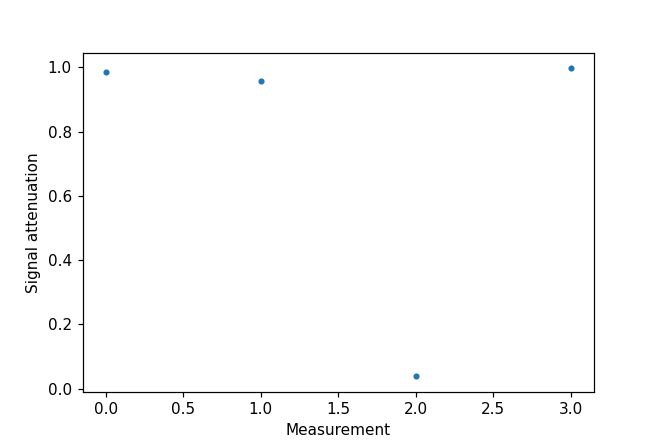

In [21]:
print(diffusion_scheme)
plt.figure(figsize=(6, 4))
plt.plot(diffusion_model(diffusion_scheme), '.')
plt.xlabel('Measurement')
plt.ylabel('Signal attenuation');

## 7. Calculate the Cramer-Rao lower bound loss again
It should be lower after optimizing the acquisition.

In [22]:
jacobian = diffusion_model.jacobian(diffusion_scheme)  # Jacobian of the signal with respect to the relevant tissue parameters.
scales = [p.scale for p in diffusion_model.get_parameters().values()]  # Tissue parameter scales.
uses = [p.use for p in diffusion_model.get_parameters().values()]  # Tissue parameter scales.
noise_variance = 0.1
microtool.optimize.crlb_loss(jacobian, scales, uses, noise_variance)

0.7887307688184341